In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [6]:
from datetime import datetime as dt

In [9]:
koubei = pd.read_csv(
    'data/ijcai2016_koubei_train'
    , header=None, names=['user_id', 'merchant_id', 'location_id', 'timestamp']
#     , dtype=str
#     , parse_dates=[3]
#     , nrows=10
)

In [7]:
koubei['timestamp'] = koubei.timestamp.map(lambda d: dt.strptime(str(d), '%Y%m%d'))

In [4]:
pred = pd.read_csv('data/ijcai2016_koubei_test', header=None, names=['user_id', 'location_id'])

# 用户-商家-地理位置的简单关联

从总体来看，10 月和 11 月命中的“用户-商家-位置”的数目和占比。

In [16]:
koubei11 = koubei[koubei.timestamp.between(20151101, 20151131)][['user_id', 'location_id', 'merchant_id']].drop_duplicates()
koubei10 = koubei[koubei.timestamp.between(20151001, 20151030)][['user_id', 'location_id', 'merchant_id']].drop_duplicates()
hit1011 = pd.merge(
    koubei10,
    koubei11,
    on=['user_id', 'location_id', 'merchant_id'], how='inner'
).drop_duplicates()
print('Same (user, merchant, location): %d' % len(hit1011))
print('Taking %.2f%% of Oct.' % (len(hit1011) / float(len(koubei10)) * 100))
print('Taking %.2f%% of Nov.' % (len(hit1011) / float(len(koubei11)) * 100))

Same (user, merchant, location): 60496
Taking 45.15% of Oct.
Taking 30.95% of Nov.


In [17]:
hit1011_ul = pd.merge(
    koubei10[['user_id', 'location_id']],
    koubei11[['user_id', 'location_id']],
    on=['user_id', 'location_id'], how='inner'
).drop_duplicates()
print('Same (user, merchant, location): %d' % len(hit1011))
print('Same (user, location): %d' % len(hit1011_ul))
print('Ratio of #(user, merchant, location) / #(user, location): %.2f%%' % (len(hit1011) / float(len(hit1011_ul)) * 100))

Same (user, merchant, location): 60496
Same (user, location): 64539
Ratio of #(user, merchant, location) / #(user, location): 93.74%


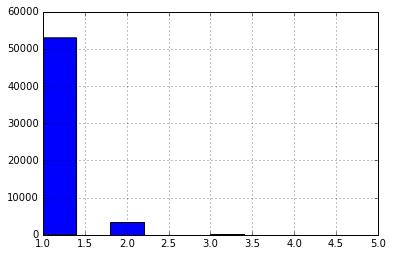

In [21]:
hit1011.groupby(['user_id', 'location_id']).merchant_id.size().hist();

# 交集用户推荐

由 Explore-Train 的可视化分析图可以看到，一个用户最终选择的商家基本上和之前去过的商家是类似的。“用户-商家”的热点图中，上个月和上两个月类似，也就是说可以直接根据*上个月的消费记录*推测出这个月这个用户会光顾的商家。

但是这种方法有两个缺点：

1. 预测用户不全，只能预测出大概 10% 的“用户-地点”记录，并且，这部分用户的预测准确率也只有大概 90%；
2. 商家的预算是有限的，最终可能并不能容纳预测出来的用户。

In [22]:
koubei12 = pd.merge(
    koubei[koubei.timestamp.between(20151101, 20151131)][['user_id', 'location_id', 'merchant_id']].drop_duplicates(),
    pred[['user_id', 'location_id']].drop_duplicates(),
    on=['user_id', 'location_id'], how='inner'
).drop_duplicates()

In [23]:
koubei12.head()

,user_id,location_id,merchant_id
0,1765014,172,6540
1,1765014,172,263
2,1406251,172,6540
3,1406251,172,820
4,408834,172,6540


In [29]:
s = koubei12.groupby(['user_id', 'location_id']).merchant_id.agg(lambda d: ':'.join([str(i) for i in d]))

In [30]:
s.head()

user_id  location_id
42       337                  820
89       188                 7667
97       84                  3538
206      83             2606:2466
234      138             221:8898
Name: merchant_id, dtype: object

In [32]:
s.to_csv('submit/0425.csv')